In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting.projects.csi_pecarn.tree_functions import *

from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting


/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
#df_all = Dataset().get_data()
df_ran = Dataset().get_data(control_types=['ran'])
#df_moi = Dataset().get_data(control_types=['moi'])
#df_ems = Dataset().get_data(control_types=['ems'])

In [3]:
av_list = ['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'NonAmbulatory', 'csi_injury']

In [4]:
def data_preparation(df, av, age, outside):
    posthoc_columns = [col for col in df.columns if 'posthoc' in col]
    outside_columns = [col for col in df.columns if 'outside' in col]
    improved_columns = [col for col in df.columns if 'improved' in col]
    pt_columns = [col for col in df.columns if 'Pt' in col]
    AVPU_columns = [col for col in df.columns if 'AVPUDetails_AVPU' in col]
    
    av_list = ['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'NonAmbulatory', 'csi_injury']
    
    if age == '<2':
        df = df[df['VeryYoung'] == 1]
    elif age == '2-5':
        df = df[(df['NonVerbal'] == 1) & (df['VeryYoung'] == 0)]
    elif age == '5-12':
        df = df[(df['YoungAdult'] == 0) & (df['NonVerbal'] == 0)]
    elif age == '>12':
        df = df[df['YoungAdult'] == 1]
    elif age == "<5":
        df = df[df['NonVerbal'] == 1]
        
    df = df.drop(['VeryYoung', 'NonVerbal','YoungAdult',
                 'MotorGCS','GCSEye','VerbalGCS','TotalGCS',
                 'Gastrointestinal', 'Cardiovascular'],axis=1).copy()
    # 'ReceivedInTransfer','CervicalSpineImmobilization'
    df = df.drop(pt_columns,axis=1).copy()
    df = df.drop(AVPU_columns,axis=1).copy()
    
    
    if av:
        df = df[av_list]
    elif outside:
        df = df.drop(posthoc_columns,axis=1).copy()
        df = df.drop(improved_columns,axis=1).copy() 
    else:
        df = df.drop(posthoc_columns,axis=1).copy()
        df = df.drop(outside_columns,axis=1).copy()  
        df = df.drop(improved_columns,axis=1).copy() 
    
    if age == '<2':
        df = df.drop(['NonAmbulatory'],axis=1).copy()
            
    return df

#### Leonard et al(2011)

The sensitivity and specificity of the rule proposed by Leonard et al(2011) in three control groups

In [5]:
Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck',
           'Torticollis','SubInj_TorsoTrunk',
           'Predisposed','HighriskDiving','HighriskMVC']

## Age > 12

(511, 36)


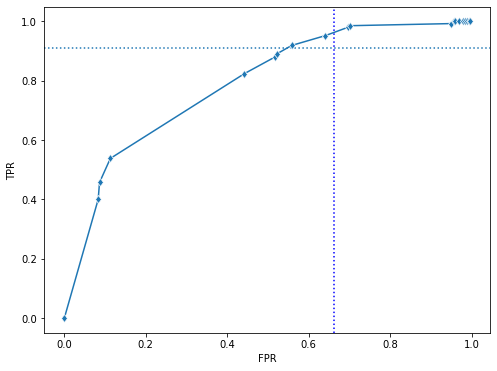

In [6]:
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '>12', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '>12', outside = False)
frames = [data_train,data_tuning]
data = pd.concat(frames)
print(data.shape)

Leo_evaluation = evaluate_vlist(data, Leonard)

results = simple_tree([data,data], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_training['TPR'], 'FPR' :e_training['FPR'] })
df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/12+vlist.csv')


In [7]:
df

,variable,TPR,FPR
0,FocalNeuroFindings,0.000000,0.000000
1,HighriskDiving,0.400000,0.083056
2,GCSbelowThreshold,0.457143,0.086379
3,PainNeck,0.538095,0.112957
4,SubInj_Head,0.823810,0.441860
5,axialloadtop,0.880952,0.518272
6,HEENT,0.890476,0.521595
7,TenderNeck,0.919048,0.558140
8,HighriskMVC,0.952381,0.641196
9,Torticollis,0.980952,0.697674


## 5 < Age < 12

(345, 36)


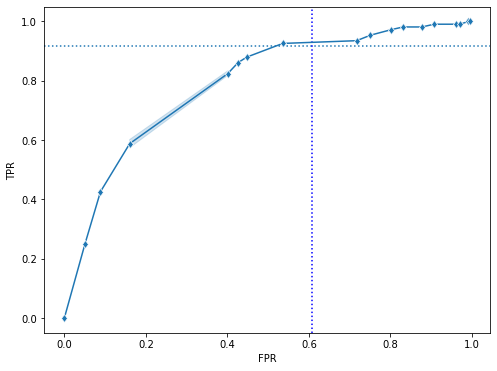

In [8]:
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '5-12', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '5-12', outside = False)
frames = [data_train,data_tuning]
data = pd.concat(frames)
print(data.shape)

Leo_evaluation = evaluate_vlist(data, Leonard)

results = simple_tree([data,data], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_training['TPR'], 'FPR' :e_training['FPR'] })
df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/5-12vlist.csv')


In [9]:
df

,variable,TPR,FPR
0,FocalNeuroFindings,0.000000,0.000000
1,GCSbelowThreshold,0.250000,0.050633
2,Torticollis,0.425926,0.088608
3,HighriskDiving,0.574074,0.160338
4,PainNeck,0.601852,0.160338
5,Predisposed,0.814815,0.400844
6,Clotheslining,0.824074,0.400844
7,SubInj_TorsoTrunk,0.833333,0.400844
8,HighriskFall,0.861111,0.426160
9,AxialLoadAnyDoc,0.879630,0.447257


## 2 < Age < 5

(151, 36)


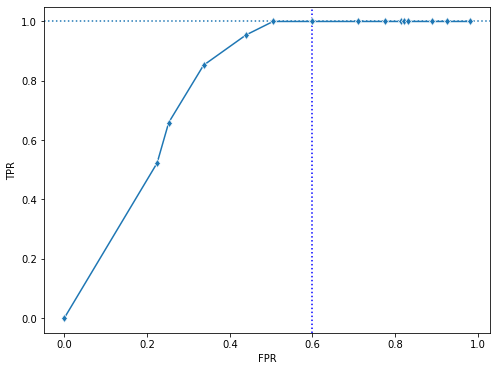

In [10]:
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '2-5', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '2-5', outside = False)
frames = [data_train,data_tuning]
data = pd.concat(frames)
print(data.shape)

Leo_evaluation = evaluate_vlist(data, Leonard)

results = simple_tree([data,data], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_training['TPR'], 'FPR' :e_training['FPR'] })
df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/2-5vlist.csv')


In [11]:
df

,variable,TPR,FPR
0,AlteredMentalStatus,0.000000,0.000000
1,FocalNeuroFindings,0.522727,0.224299
2,Torticollis,0.659091,0.252336
3,Predisposed,0.840909,0.336449
4,HighriskMVC,0.863636,0.336449
5,PosMidNeckTenderness,0.954545,0.439252
6,LOC,1.000000,0.504673
7,PainNeck,1.000000,0.598131
8,SubInj_Head,1.000000,0.710280
9,SubInj_Ext,1.000000,0.775701


## Age < 2

(93, 35)


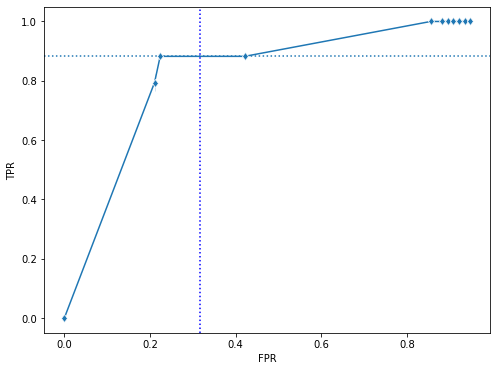

In [12]:
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '<2', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '<2', outside = False)
frames = [data_train,data_tuning]
data = pd.concat(frames)
print(data.shape)

Leo_evaluation = evaluate_vlist(data, Leonard)

results = simple_tree([data,data], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_training['TPR'], 'FPR' :e_training['FPR'] })
df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/2-vlist.csv')


In [13]:
df

,variable,TPR,FPR
0,AlteredMentalStatus,0.000000,0.000000
1,PosMidNeckTenderness,0.764706,0.210526
2,Predisposed,0.823529,0.210526
3,AxialLoadAnyDoc,0.882353,0.223684
4,EMSArrival,0.882353,0.421053
5,HighriskFall,1.000000,0.855263
6,HighriskMVC,1.000000,0.881579
7,Assault,1.000000,0.894737
8,HEENT,1.000000,0.907895
9,Respiratory,1.000000,0.921053
